In [1]:
import os
import pandas as pd
import numpy as np
import pgeocode
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from typing import defaultdict
from pandarallel import pandarallel

In [2]:
data_path = '..\\data\\'

In [3]:
clients_data = pd.read_csv(data_path + 'train_data_npo\\npo_clnts.csv')

In [42]:
def columns_report(data: pd.DataFrame) -> None:

    print('Rows:', data.shape[0], end='\n'*2)

    stats = defaultdict(list)
    for col in data.columns:
        stats['Column'].append(col)
        stats['Unique'].append(data[col].nunique())
        stats['Duplicates'].append(data[col].duplicated().sum())
        stats['Missing'].append(data[col].isna().sum())
        stats['Missing%'].append(data[col].isna().mean() * 100)
        stats['HitRate%'].append((1 - data[col].isna().mean()) * 100)
    stats = pd.DataFrame(stats)

    print(stats.to_string(index=False))

In [70]:
clients_cleaned = clients_data.copy()

In [44]:
clients_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230446 entries, 0 to 230445
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clnt_id     230446 non-null  object 
 1   gndr        230442 non-null  float64
 2   slctn_nmbr  230446 non-null  int64  
 3   age         230423 non-null  float64
 4   brth_yr     230423 non-null  float64
 5   pstl_code   220185 non-null  object 
 6   city        230446 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 12.3+ MB


In [71]:
columns_report(clients_cleaned)

Rows: 230446

    Column  Unique  Duplicates  Missing  Missing%   HitRate%
   clnt_id  230407          39        0  0.000000 100.000000
      gndr       2      230443        4  0.001736  99.998264
slctn_nmbr       4      230442        0  0.000000 100.000000
       age     120      230325       23  0.009981  99.990019
   brth_yr     120      230325       23  0.009981  99.990019
 pstl_code   20869      209576    10261  4.452670  95.547330
      city       2      230444        0  0.000000 100.000000


In [45]:
postal_code_pattern = r'^\d{6}$'
clients_cleaned['pstl_code'] = clients_cleaned.pstl_code.str.replace('.0', '')
clients_cleaned.loc[~(clients_cleaned.pstl_code.str.match(postal_code_pattern, na=False)), 'pstl_code'] = np.nan
clients_cleaned['pstl_code'] = clients_cleaned.pstl_code.astype(float).fillna(-1).astype(int).astype(str)\
    .replace('-1', '_MISSING_')
pcode_mode = clients_cleaned.loc[clients_cleaned.pstl_code != '_MISSING_', 'pstl_code'].mode()[0]
clients_cleaned['pstl_code']= clients_cleaned.pstl_code.replace('_MISSING_', pcode_mode)

In [46]:
postal_decoder = pgeocode.Nominatim('ru')

def get_geosub_from_postalcode(postal_code: str, decoder=postal_decoder) -> str:

    geo = decoder.query_postal_code(postal_code).state_name

    return geo

In [47]:
print(os.cpu_count())

16


In [48]:
# получение геопозиции по почтовому индексу
pandarallel.initialize(progress_bar=True, nb_workers=12)
clients_cleaned['geo'] = clients_cleaned.pstl_code.parallel_apply(get_geosub_from_postalcode)

In [56]:
# заполнение недостающих геопозиций по индексам с такой же частью, отвечающей за код города
no_geo_pstl_codes = clients_cleaned.loc[clients_cleaned.geo.isna(), 'pstl_code'].unique().tolist()

for pstl_code in no_geo_pstl_codes:
    no_geo_city_code = pstl_code[:3]
    try:
        twin_geo = clients_cleaned.loc[(clients_cleaned.pstl_code.str[:3] == no_geo_city_code) &\
            (clients_cleaned.geo.notna()), 'geo'].unique()[0]
    except IndexError:
        twin_geo = None
    clients_cleaned.loc[clients_cleaned.pstl_code == pstl_code, 'geo'] = twin_geo

In [65]:
clients_cleaned.dropna(subset=['gndr', 'age', 'brth_yr', 'geo'], inplace=True)
clients_cleaned.drop_duplicates(subset=['clnt_id'], keep='first', inplace=True)
clients_cleaned.reset_index(drop=True, inplace=True)

In [85]:
clients_cleaned['gndr'] = clients_cleaned.gndr.astype(int)
clients_cleaned['age'] = clients_cleaned.age.astype(int)
clients_cleaned['brth_yr'] = clients_cleaned.brth_yr.astype(int)

In [186]:
columns_report(clients_cleaned)

Rows: 229519

    Column  Unique  Duplicates  Missing  Missing%  HitRate%
   clnt_id  229519           0        0       0.0     100.0
      gndr       2      229517        0       0.0     100.0
slctn_nmbr       4      229515        0       0.0     100.0
       age     120      229399        0       0.0     100.0
   brth_yr     120      229399        0       0.0     100.0
 pstl_code   14211      215308        0       0.0     100.0
      city       2      229517        0       0.0     100.0
       geo      78      229441        0       0.0     100.0


In [187]:
clients_cleaned.describe(percentiles=[.01, .1, .25, .5, .75, .9, .99])

,gndr,slctn_nmbr,age,brth_yr,city
count,229519.000000,229519.000000,229519.000000,229519.000000,229519.000000
mean,0.439454,1.438896,55.755876,1966.907912,0.242202
std,0.496322,0.848230,21.520319,21.531225,0.428417
min,0.000000,0.000000,-976.000000,1.000000,0.000000
1%,0.000000,0.000000,30.000000,1931.000000,0.000000
10%,0.000000,0.000000,38.000000,1951.000000,0.000000
25%,0.000000,1.000000,46.000000,1958.000000,0.000000
50%,0.000000,2.000000,56.000000,1966.000000,0.000000
75%,1.000000,2.000000,65.000000,1977.000000,0.000000
90%,1.000000,2.000000,71.000000,1984.000000,1.000000


In [11]:
clients_cleaned = clients_cleaned.loc[(clients_cleaned.age >= 18) & (clients_cleaned.age <= 90)].reset_index(drop=True)

In [12]:
clients_cleaned.describe(percentiles=[.01, .05, .1, .25, .5, .75, .9, .95, .99])

,gndr,slctn_nmbr,age,brth_yr,city
count,226977.000000,226977.000000,226977.000000,226977.000000,226977.000000
mean,0.437428,1.443040,55.391498,1967.276178,0.237989
std,0.496070,0.851154,12.423156,12.421043,0.425853
min,0.000000,0.000000,18.000000,1932.000000,0.000000
1%,0.000000,0.000000,30.000000,1938.000000,0.000000
5%,0.000000,0.000000,35.000000,1948.000000,0.000000
10%,0.000000,0.000000,38.000000,1952.000000,0.000000
25%,0.000000,1.000000,46.000000,1958.000000,0.000000
50%,0.000000,2.000000,56.000000,1966.000000,0.000000
75%,1.000000,2.000000,64.000000,1977.000000,0.000000


In [13]:
# clients_cleaned.to_feather(data_path + '\\interim\\clnts.frt')

In [4]:
clients_cleaned = pd.read_feather(data_path + '\\interim\\clnts.frt')

In [5]:
print('Сохраненная доля исходной выборки: {:.2%}'.format(clients_cleaned.shape[0] / clients_data.shape[0]))

Сохраненная доля исходной выборки: 98.49%


In [6]:
clients_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226977 entries, 0 to 226976
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clnt_id     226977 non-null  object
 1   gndr        226977 non-null  int32 
 2   slctn_nmbr  226977 non-null  int64 
 3   age         226977 non-null  int32 
 4   brth_yr     226977 non-null  int32 
 5   pstl_code   226977 non-null  object
 6   city        226977 non-null  int64 
 7   geo         226977 non-null  object
dtypes: int32(3), int64(2), object(3)
memory usage: 11.3+ MB


In [7]:
sns.set_palette('dark')

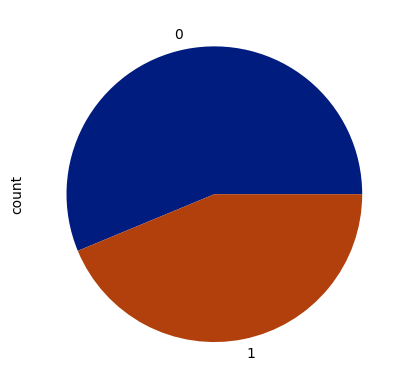

In [8]:
clients_cleaned.gndr.value_counts().plot(kind='pie')
plt.show()

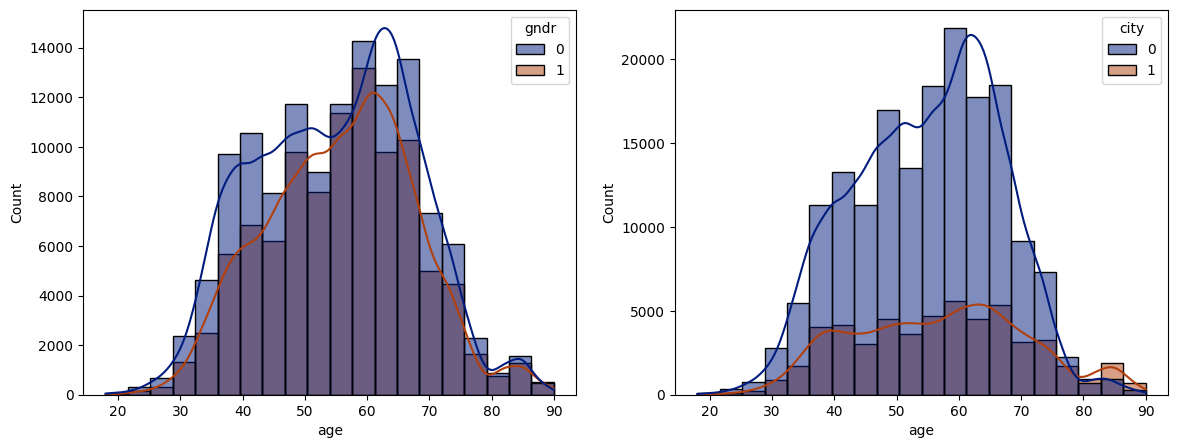

In [32]:
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(14)
fig.set_figheight(5)
sns.histplot(clients_cleaned, x='age', hue='gndr', bins=20, kde=True, ax=ax[0])
sns.histplot(clients_cleaned, x='age', hue='city', bins=20, kde=True, ax=ax[1])
plt.show()

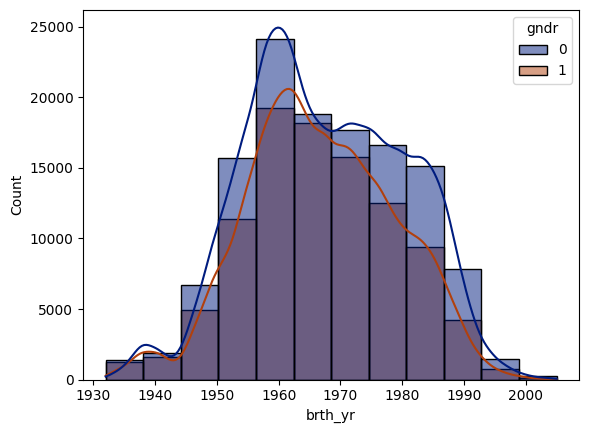

In [29]:
sns.histplot(clients_cleaned, x='brth_yr', hue='gndr', bins=12, kde=True)
plt.show()

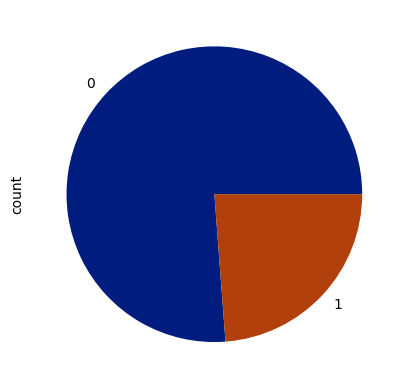

In [25]:
clients_cleaned.city.value_counts().plot(kind='pie')
plt.show()

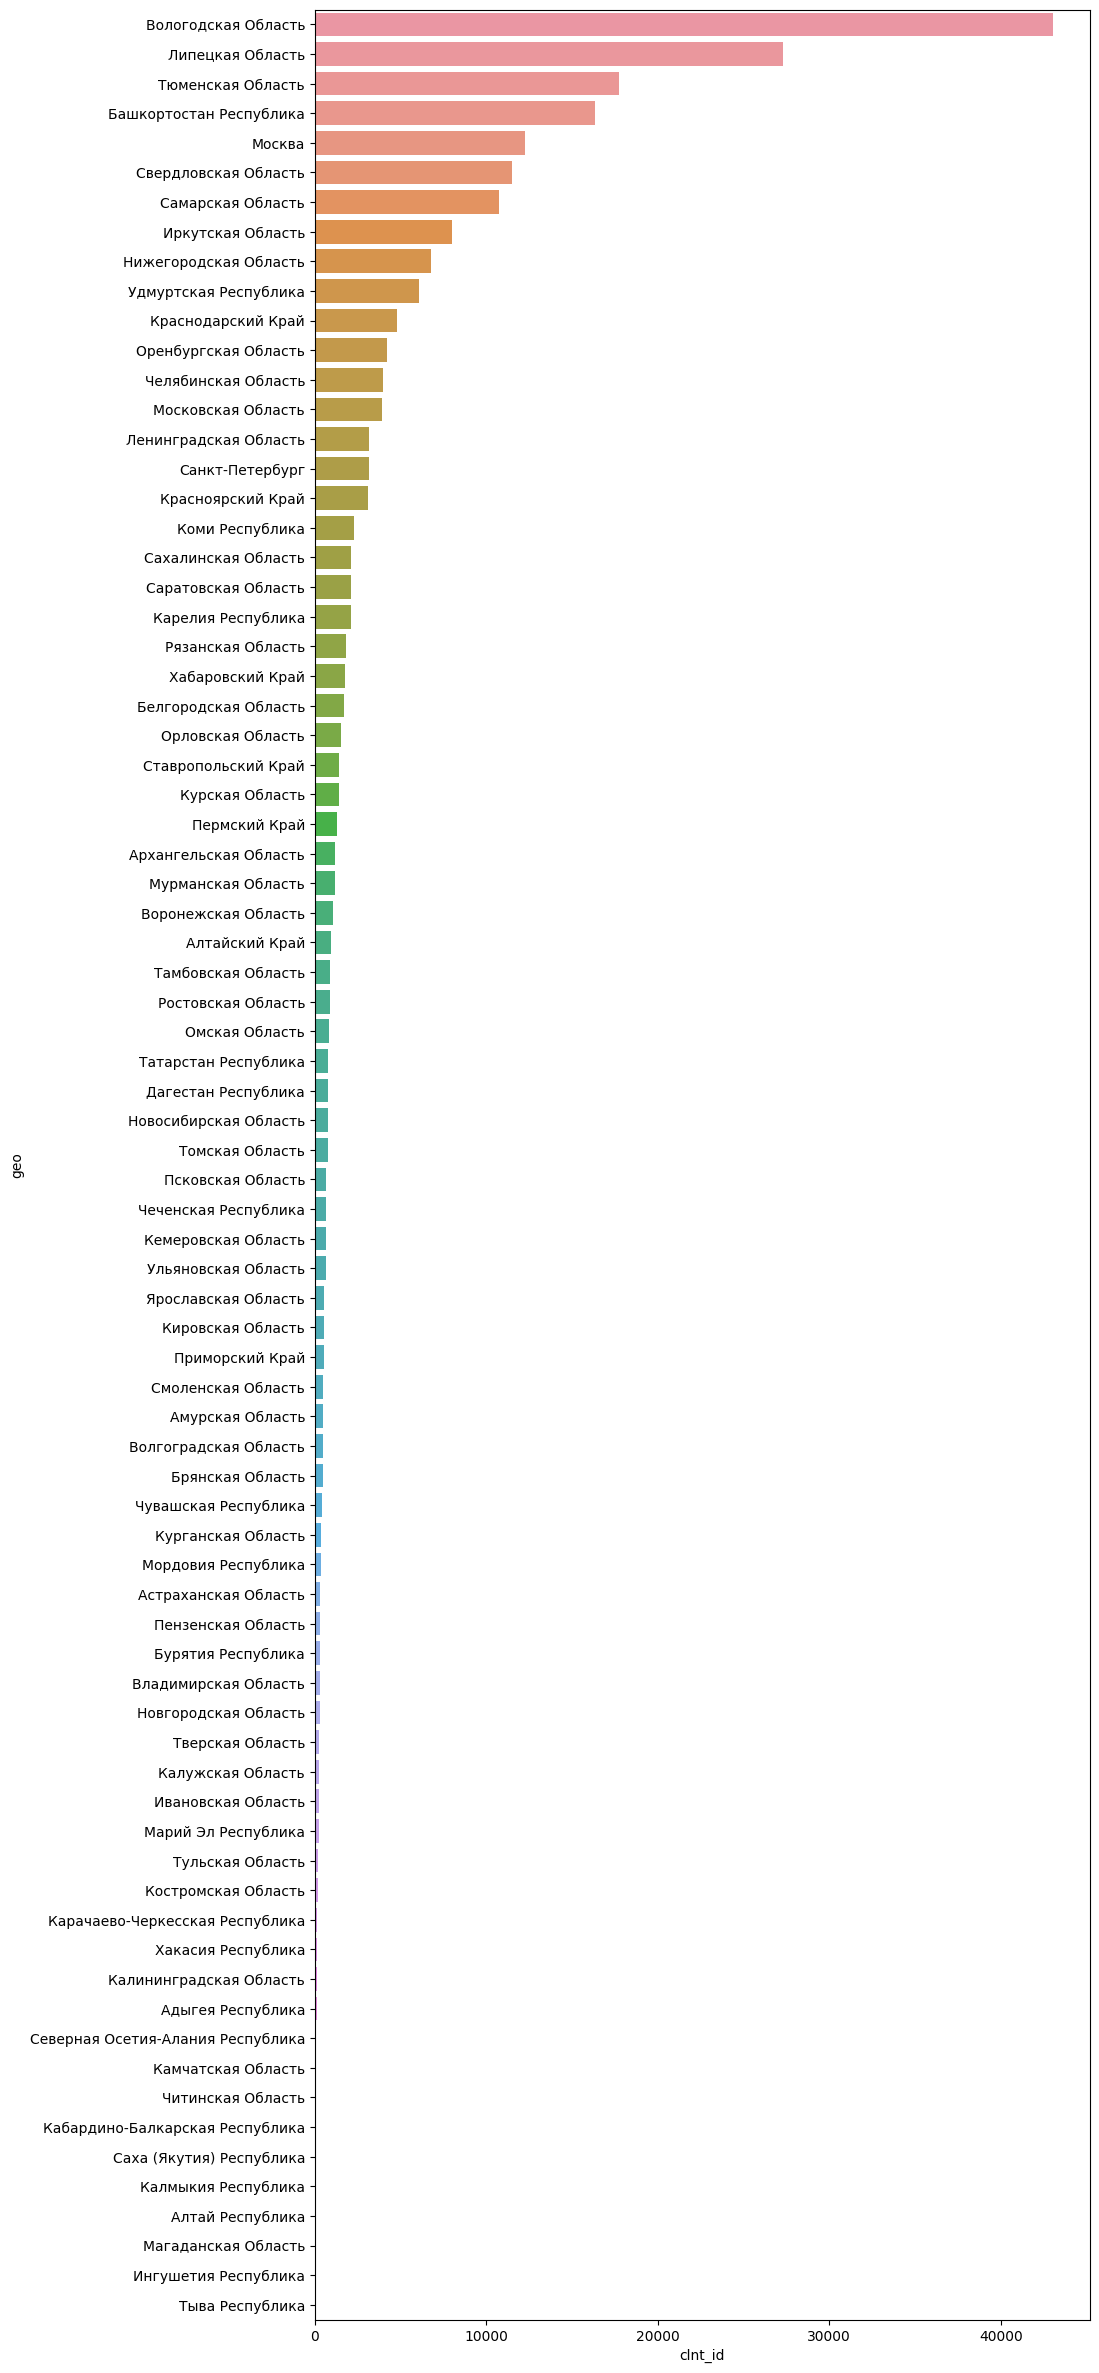

In [45]:
plt.figure(figsize=(10, 30))
sns.barplot(clients_cleaned.groupby('geo', as_index=False).clnt_id.count().sort_values('clnt_id', ascending=False),
            x='clnt_id', y='geo')
plt.show()